
# E4 Preprocessing and data modelling

In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Signal processing stuff
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.stats as stats
# Machine learning stuff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import math
import os


In [26]:
# Definitions
dataset_dir = '../../original_dataset/'
PERSONS = 17
acceleration_data_loc = dataset_dir + 'P{:02d}/E4/ACC.csv'
VO2_data_loc = dataset_dir + 'P{:02d}/VO2/DataAverage.csv'
# Exercise lasts for 30 minutes
duration_of_exercise = 30 * 60
WINDOW_SIZE = 320

In [27]:
def load_acc_data(person):
    data = pd.read_csv(acceleration_data_loc.format(person))
    return data
def load_vo2_avg_data(person):
    data = pd.read_csv(VO2_data_loc.format(person))
    return data

def sync_acc_with_VO2(person):
    e4_data = load_acc_data(person)
    # Timestamp is first column
    E4_start_timestamp_num = e4_data.columns[0]
    E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')
    # Rename column
    e4_data.columns = ['X', 'Y', 'Z']
    # First row of e4 data is the sample rate number, identical for all three channels. Take it and crop the rest
    sample_rate = e4_data['X'][0]
    e4_data = e4_data[1:]
    max_time = len(e4_data) / sample_rate

    # Get VO2 data
    VO2_average_data = load_vo2_avg_data(person)
    # Get the first timestamp from VO2 data column 'Time', which is a datetime
    VO2_timestamp = VO2_average_data['Time'].iloc[0]
    VO2_timestamp = pd.to_datetime(VO2_timestamp)

    # If timestamps do not match, then cut the start of the HR data to match the start of the VO2 data
    if E4_start_timestamp != VO2_timestamp:
        total_seconds = (VO2_timestamp - E4_start_timestamp).total_seconds()
        # Cut the start of the HR data to match the start of the VO2 data
        e4_data = e4_data.iloc[int(total_seconds):, :]
        max_time = len(e4_data) / sample_rate
        # Reset the time array
        time = np.linspace(0, max_time, len(e4_data))
    
    # If the E4 data is still longer than VO2 data, then cut the end of the E4 data to match the end of the VO2 data
    if max_time > duration_of_exercise:
        e4_data = e4_data.iloc[:int(duration_of_exercise * sample_rate), :]
        time = np.linspace(0, duration_of_exercise, len(e4_data))
        max_time = len(e4_data) / sample_rate

    # # Plot the data
    # plt.figure()
    # plt.plot(time, e4_data['X'], label='X')
    # plt.plot(time, e4_data['Y'], label='Y')
    # plt.plot(time, e4_data['Z'], label='Z')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Acceleration [g]')
    # plt.legend()
    # plt.title('E4 Acceleration Data')
    # plt.show()

    # Take the average of each second in e4 data, reduce the sample rate to 1 Hz
    e4_data = e4_data.groupby(e4_data.index // sample_rate).mean()

    # Create Time array of DateTime objects from the start timestamp to the end timestamp
    time = np.linspace(round(float(E4_start_timestamp_num)), round(float(E4_start_timestamp_num) + float(max_time)), round(max_time))
    time = pd.to_datetime(time, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time) < len(e4_data):
        time = np.append(time, time[-1]+ pd.to_timedelta(1, unit='s'))
    e4_data['Time'] = time

    # Now create new time array in seconds from the start timestamp
    time_seconds = np.linspace(0, round(max_time), round(max_time))

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_seconds) < len(e4_data):
        time_seconds = np.append(time_seconds, time_seconds[-1] + 1)
    # Round each value to the 1 decimal place and add 1 to each value
    time_seconds = np.round(time_seconds, 1)+1
    e4_data['Time[s]'] = time_seconds

    # Now create delta datetime
    time_delta = np.linspace(0, max_time, round(max_time))
    time_delta = pd.to_datetime(time_delta, unit='s')

    # If e4 data is longer than the generated time, add the difference to the time array
    while len(time_delta) < len(e4_data):
        time_delta = np.append(time_delta, time_delta[-1] + pd.to_timedelta(1, unit='s'))
    e4_data['Delta_time'] = time_delta
    return e4_data, VO2_average_data

sync_acc_with_VO2(17)

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


(               X          Y          Z                 Time  Time[s]  \
 60.0    -3.00000  -0.833333 -63.958333  1638462767000000000      1.0   
 61.0    -3.00000  -0.843750 -63.875000  1638462768000555776      2.0   
 62.0    -3.00000  -0.812500 -63.906250  1638462769001111808      3.0   
 63.0    -3.00000  -0.937500 -63.875000  1638462770001667584      4.0   
 64.0    -3.00000  -0.843750 -63.843750  1638462771002223616      5.0   
 ...          ...        ...        ...                  ...      ...   
 1856.0  39.03125 -26.968750  40.656250  1638464563998332416   1798.0   
 1857.0  39.06250 -26.812500  40.781250  1638464564998888192   1799.0   
 1858.0  38.62500 -26.312500  41.468750  1638464565999444224   1800.0   
 1859.0  38.75000 -26.343750  41.343750  1638464567000000000   1801.0   
 1860.0  39.00000 -26.875000  41.000000  2021-12-02 17:02:48   1802.0   
 
                  Delta_time  
 60.0                      0  
 61.0             1000555864  
 62.0             2001111728 

In [28]:
def outlier_handling(data):
    # This method uses 2-minute windows (32Hz) and Interquartile Range (IQR) to detect outliers for each window and axis separately
    # The method returns the original data with the outliers imputed with the median of the window
    # The method also print the number of outliers detected for each axis
    WINDOW_SIZE = 1 * 60
    x_outliers, y_outliers, z_outliers = 0, 0, 0
    x_data, y_data, z_data = data['X'], data['Y'], data['Z']
    def handle_outliers_for_window(data):
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        # Impute outliers with median
        data[(data < lower_bound) | (data > upper_bound)] = data.median()
        return data, len(outliers)
    def handle_axis(axis_data):
        total_outliers = 0
        new_data = []
        windows = [axis_data[i:i+WINDOW_SIZE] for i in range(0, len(axis_data), WINDOW_SIZE)]
        for window in windows:
            new_data_window, count = handle_outliers_for_window(window)
            new_data.append(new_data_window)
            total_outliers += count
        new_data = pd.concat(new_data)
        return new_data, total_outliers
    
    x_data, x_outliers = handle_axis(x_data)
    y_data, y_outliers = handle_axis(y_data)
    z_data, z_outliers = handle_axis(z_data)
    data['X'] = x_data
    data['Y'] = y_data
    data['Z'] = z_data
    print(f'Outliers for X: {x_outliers}, Y: {y_outliers}, Z: {z_outliers}')
    return data

# ! NOTE: Outlier handling not used ATM, rolling window is used instead
# print("test")
# # Load data for person 1
# e4_data, VO2_data = sync_acc_with_VO2(1)
# e4_data_preprocessed = outlier_handling(e4_data)

# # Plot both side by side
# fig, axs = plt.subplots(2, figsize=(20, 10))
# fig.suptitle('Before and after outlier handling')
# axs[0].plot(e4_data['X'], label='X')
# axs[0].plot(e4_data['Y'], label='Y')
# axs[0].plot(e4_data['Z'], label='Z')

# axs[1].plot(e4_data_preprocessed['X'], label='X')
# axs[1].plot(e4_data_preprocessed['Y'], label='Y')
# axs[1].plot(e4_data_preprocessed['Z'], label='Z')
# axs[0].legend()
# axs[1].legend()
# plt.show()


C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


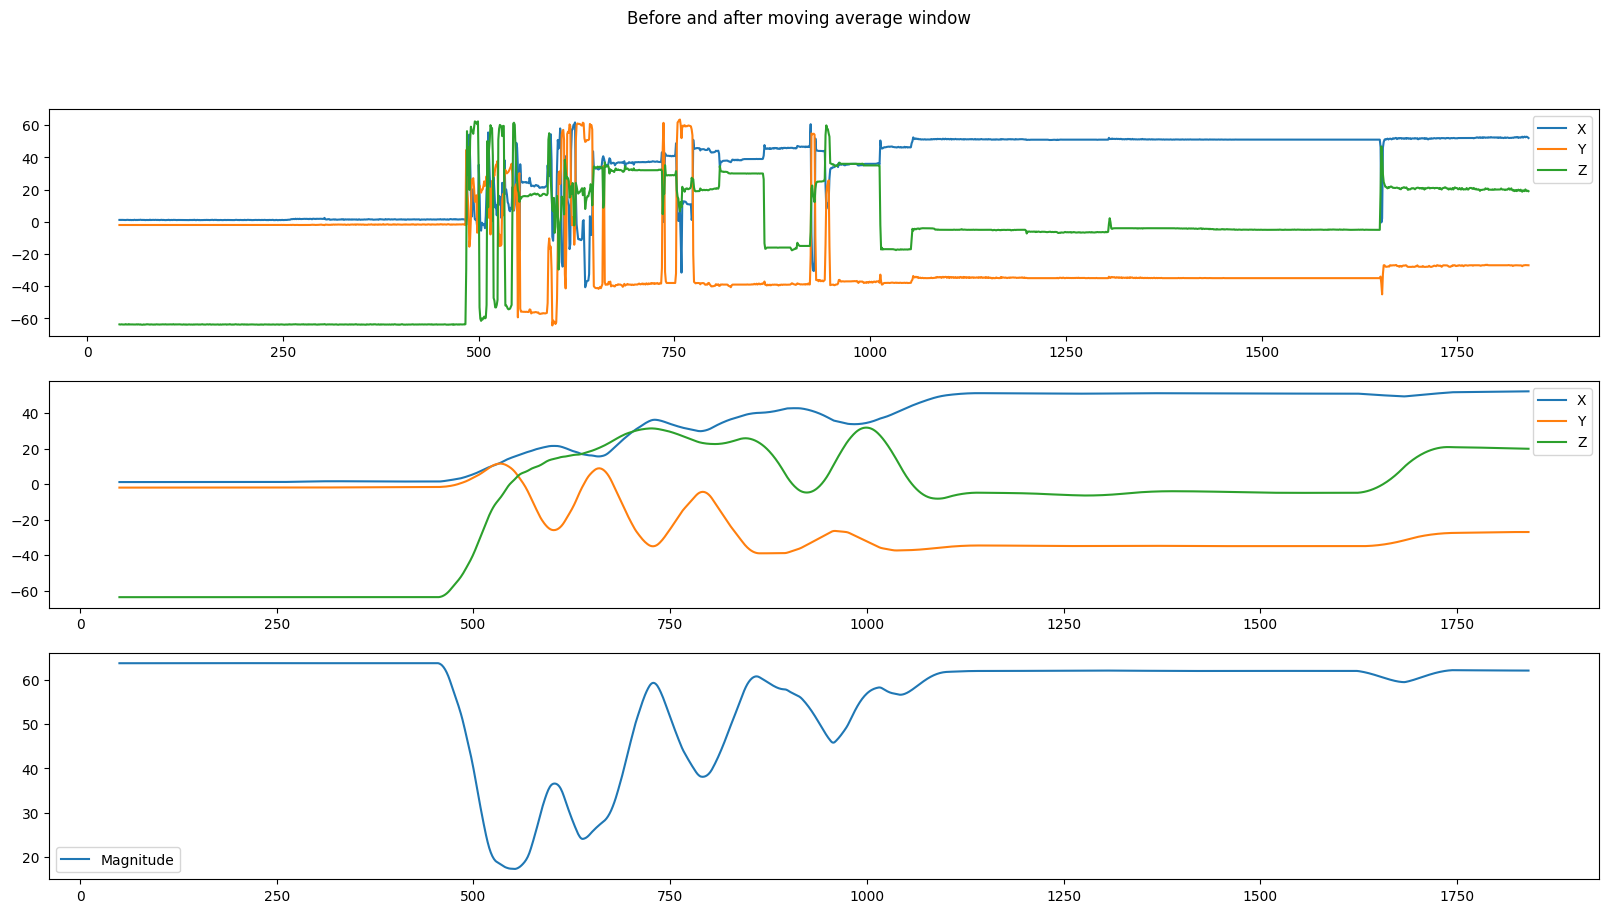

In [38]:
# Central moving average window of 1 minute
def central_moving_average(data, window_size, plot=False, person=None):
    # If plot, plot the data before and after moving average
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X')
        plt.plot(data['Y'], label='Y')
        plt.plot(data['Z'], label='Z')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person}')
        else:
            plt.title('E4 Acceleration Data')
        plt.show()
    data['X'] = data['X'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Y'] = data['Y'].rolling(window=window_size, min_periods=1, center=True).mean()
    data['Z'] = data['Z'].rolling(window=window_size, min_periods=1, center=True).mean()
    first = lambda x: x.iloc[0]
    data = data.rolling(window=window_size, min_periods=10).agg({'X': 'mean', 'Y': 'mean', 'Z': 'mean', 'Time[s]': first})
    if plot:
        plt.figure()
        plt.plot(data['X'], label='X MAW')
        plt.plot(data['Y'], label='Y MAW')
        plt.plot(data['Z'], label='Z MAW')
        plt.xlabel('Time [s]')
        plt.ylabel('Acceleration [g]')
        plt.legend()
        if person:
            plt.title(f'E4 Acceleration Data for person {person} after moving average window')
        else:
            plt.title('E4 Acceleration Data after moving average window')
        plt.show()
    return data

def compute_ACC_magnitude(data):
    return np.sqrt(data['X']**2 + data['Y']**2 + data['Z']**2)

e4_data, VO2_data = sync_acc_with_VO2(5)
import copy
e4_data_maw = copy.deepcopy(e4_data)
e4_data_maw = central_moving_average(e4_data_maw, 60)
e4_data_mag = compute_ACC_magnitude(e4_data_maw)
e4_data_maw['Magnitude'] = e4_data_mag
# Plot both side by side
fig, axs = plt.subplots(3, figsize=(20, 10))
fig.suptitle('Before and after moving average window')
axs[0].plot(e4_data['X'], label='X')
axs[0].plot(e4_data['Y'], label='Y')
axs[0].plot(e4_data['Z'], label='Z')
axs[1].plot(e4_data_maw['X'], label='X')
axs[1].plot(e4_data_maw['Y'], label='Y')
axs[1].plot(e4_data_maw['Z'], label='Z')
axs[2].plot(e4_data_mag, label='Magnitude')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


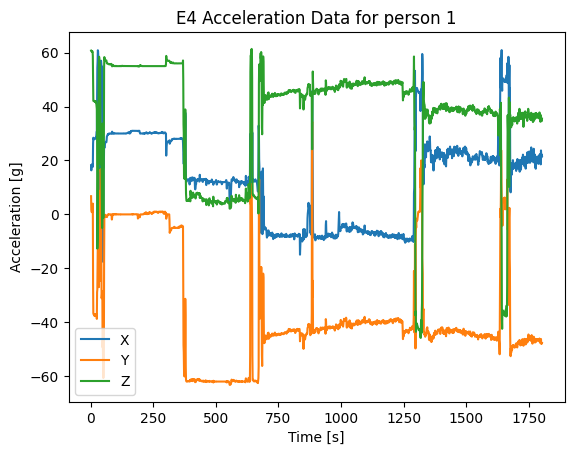

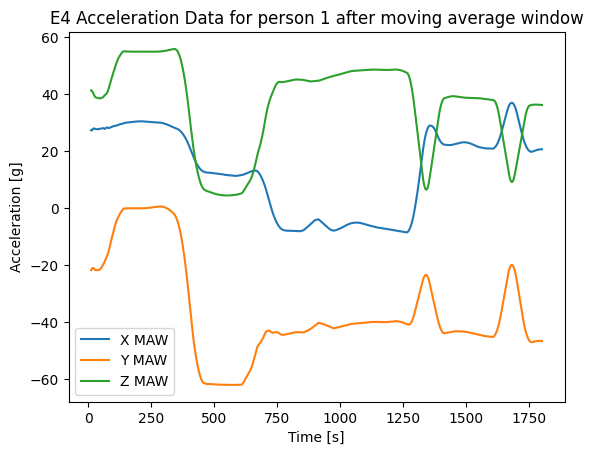

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


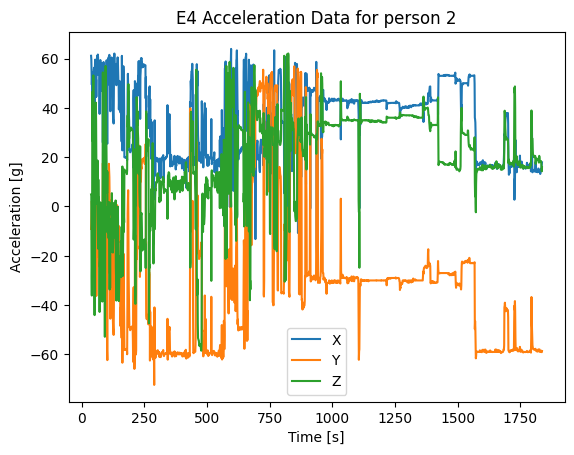

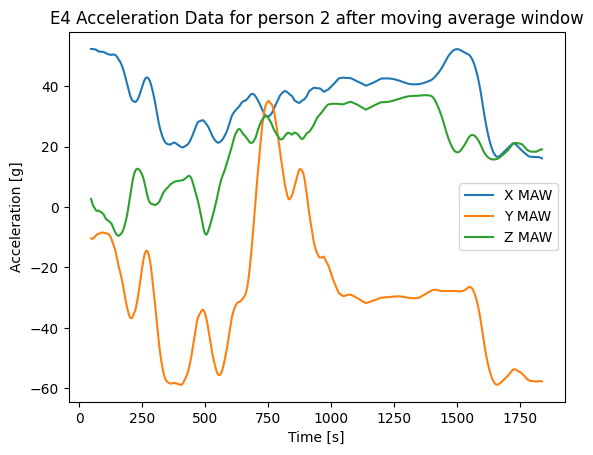

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


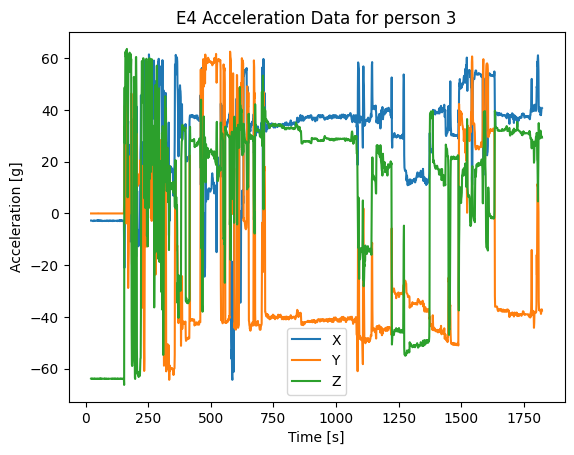

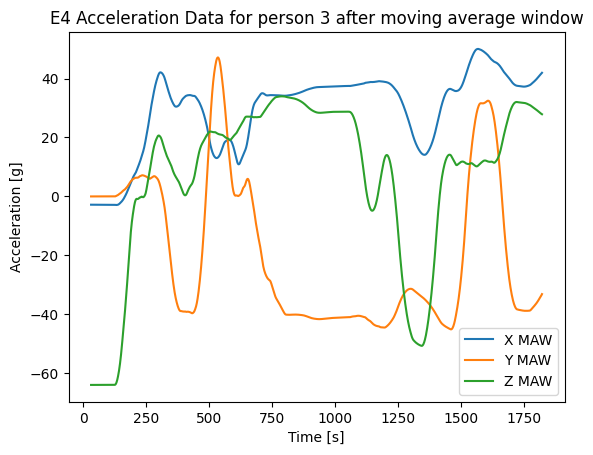

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


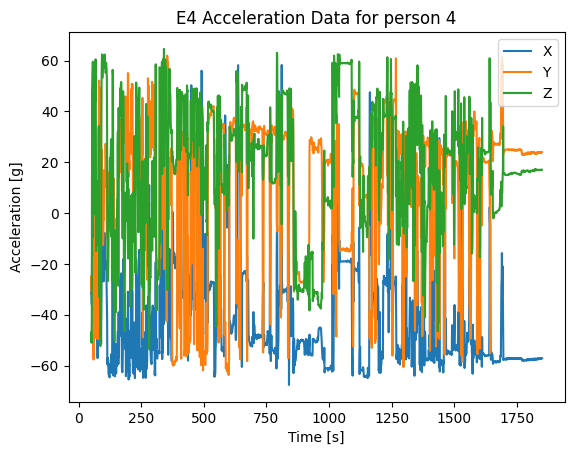

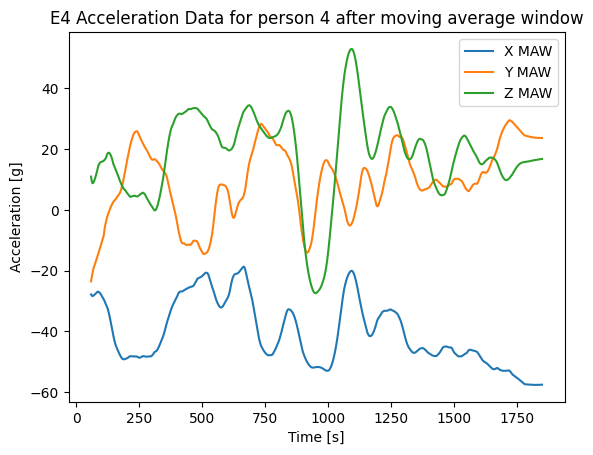

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


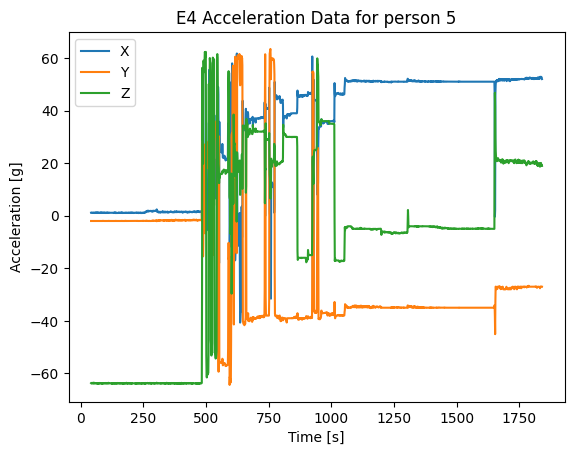

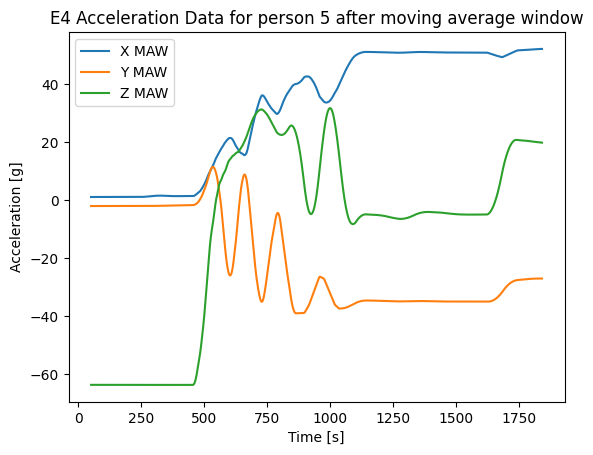

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


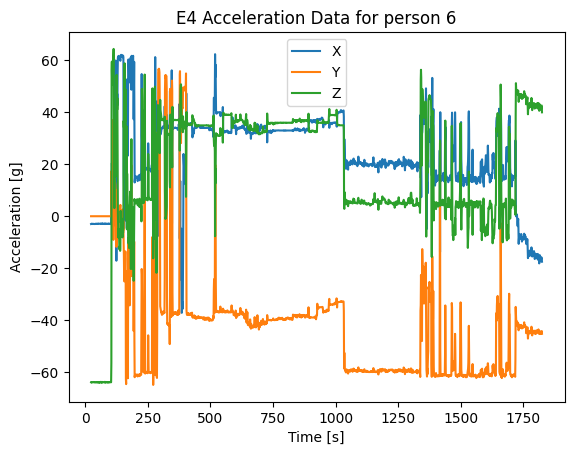

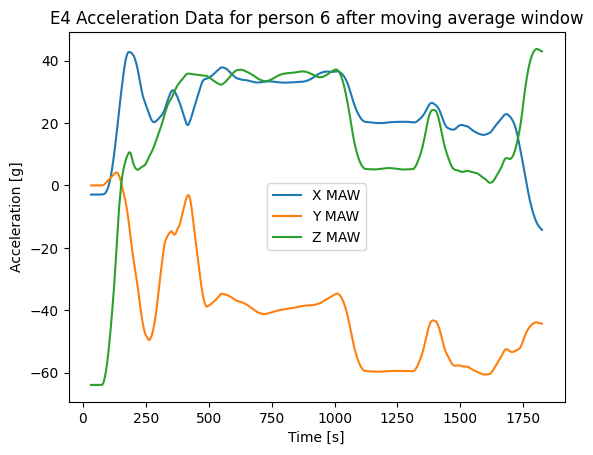

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


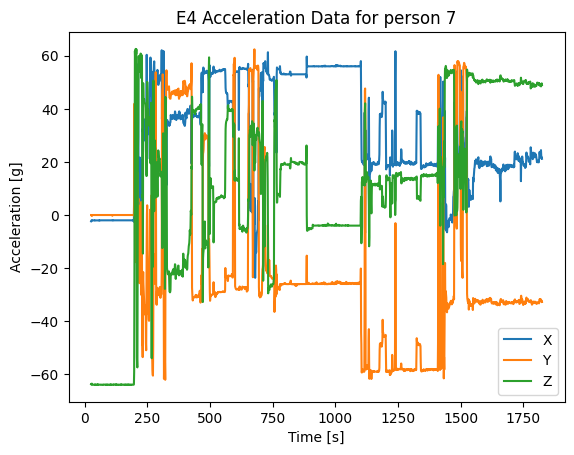

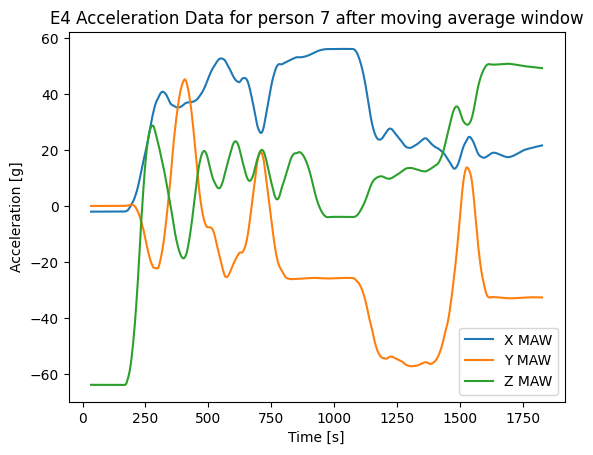

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


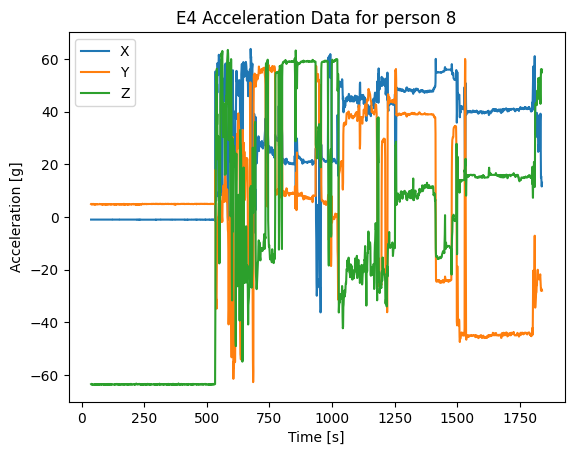

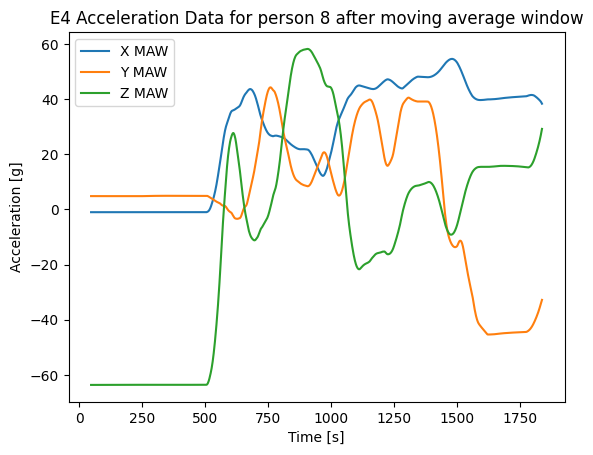

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


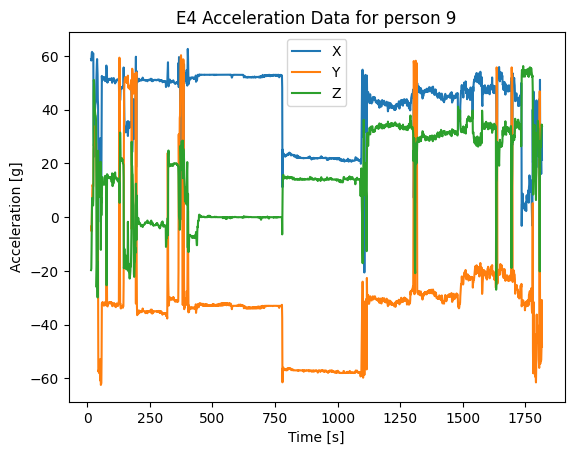

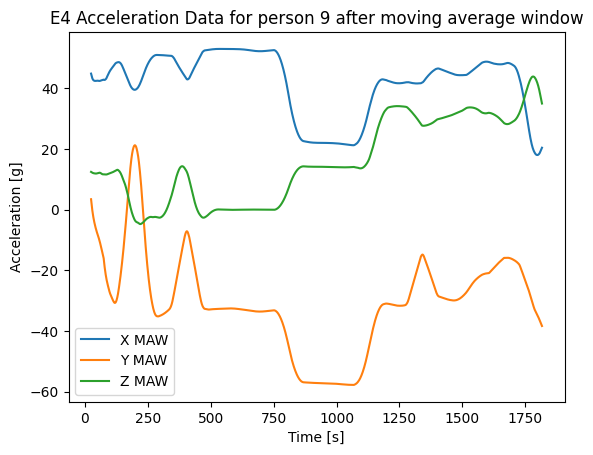

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


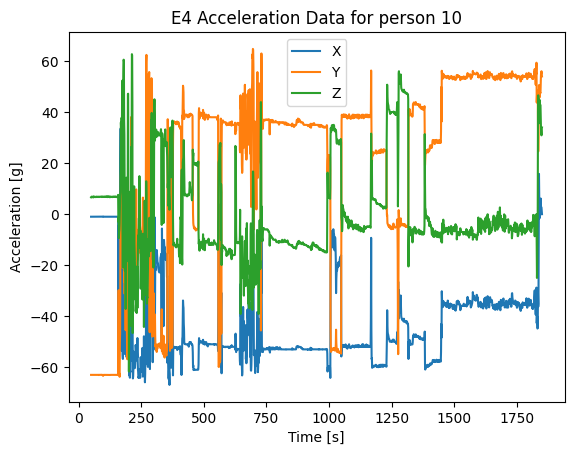

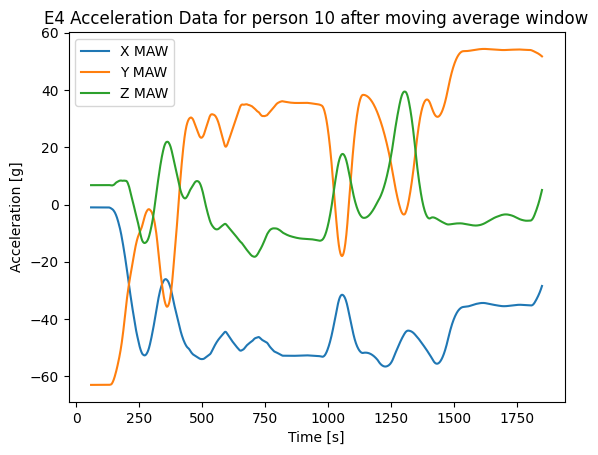

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


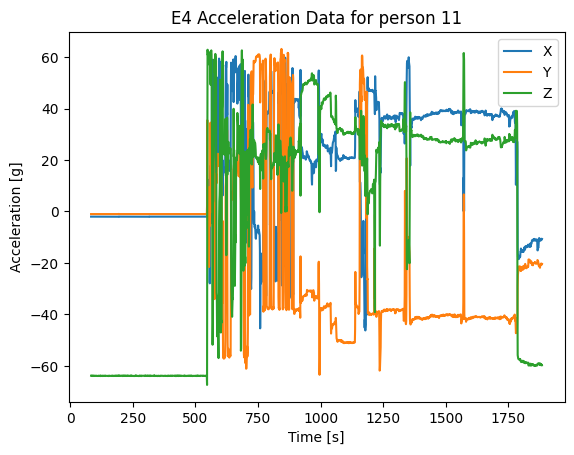

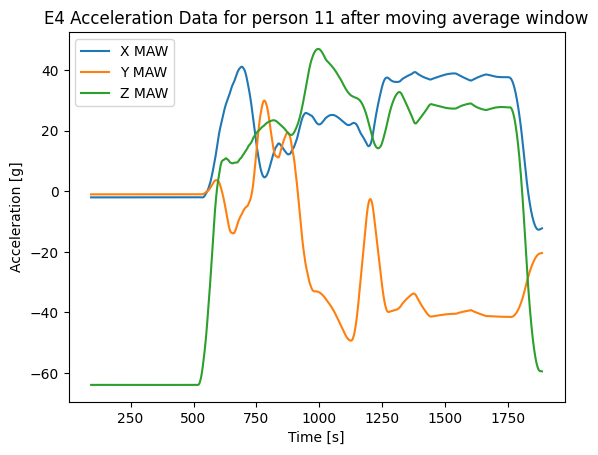

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


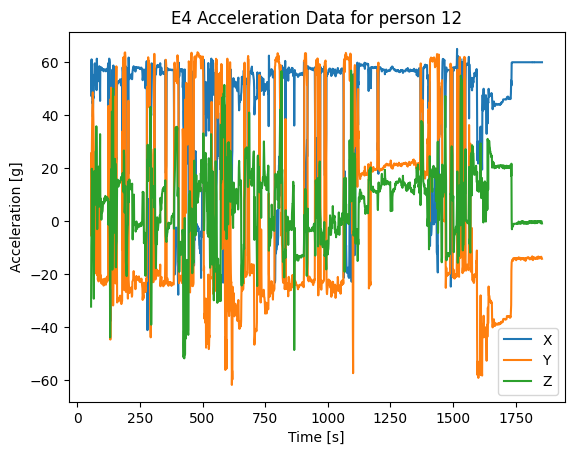

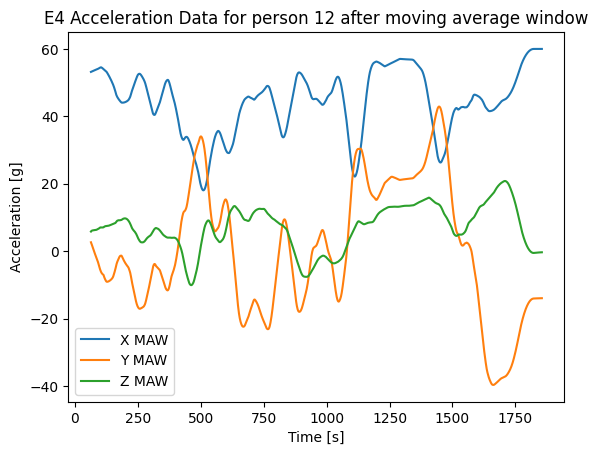

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


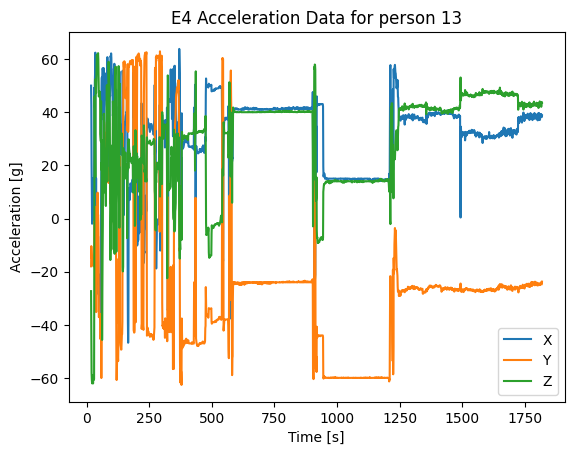

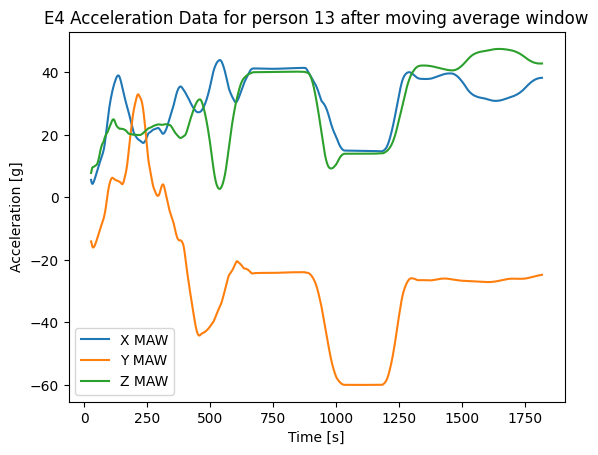

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


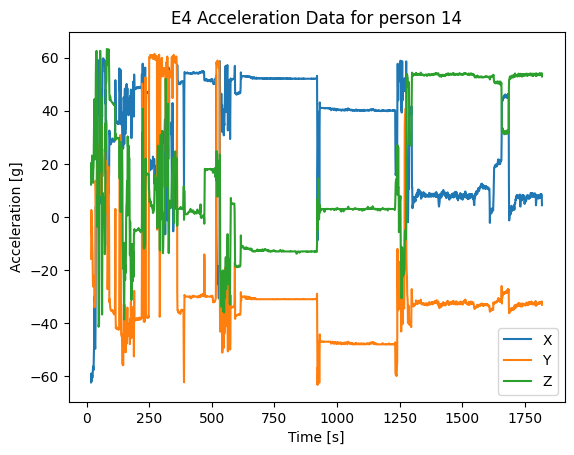

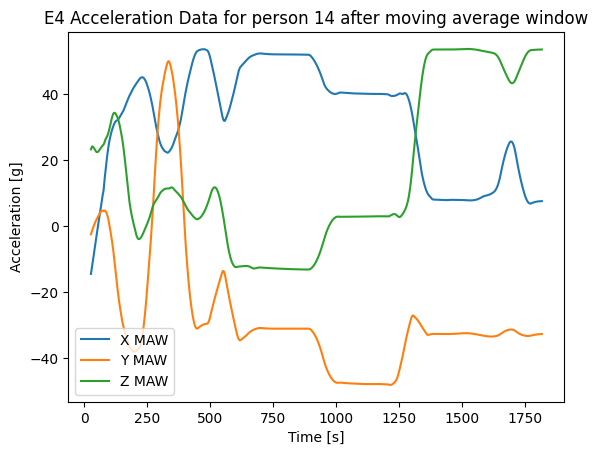

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


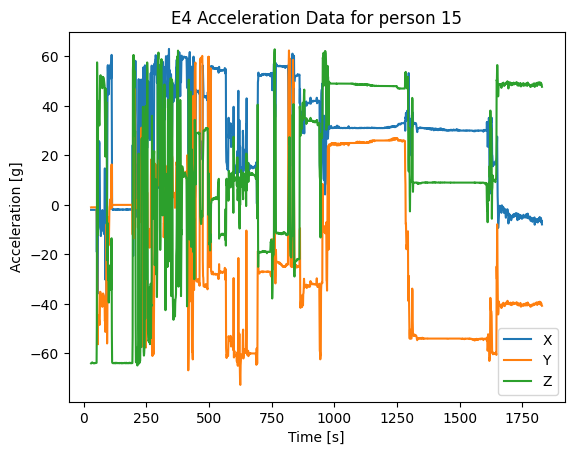

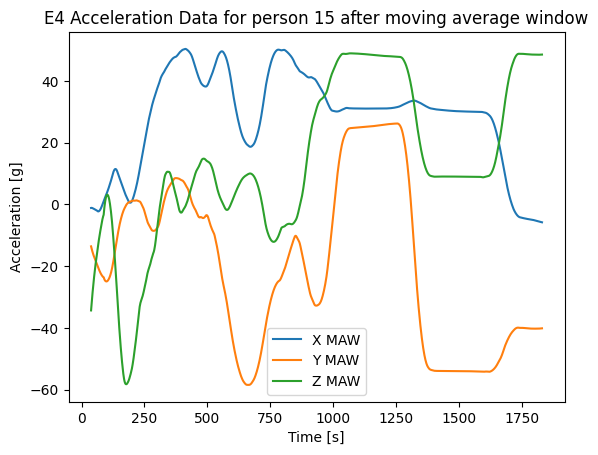

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


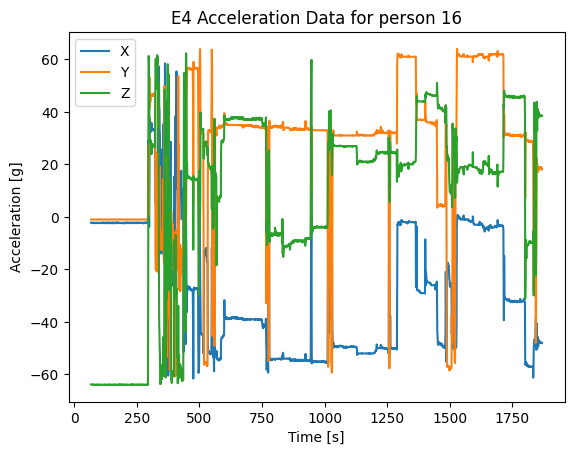

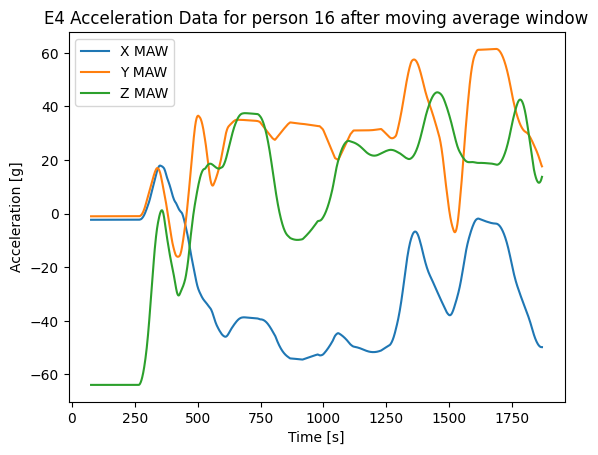

C:\Users\tiitu\AppData\Local\Temp\ipykernel_18124\3664783931.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  E4_start_timestamp = pd.to_datetime(E4_start_timestamp_num, unit='s')


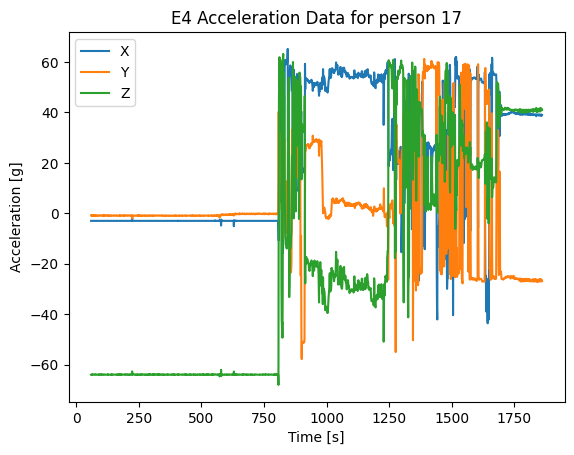

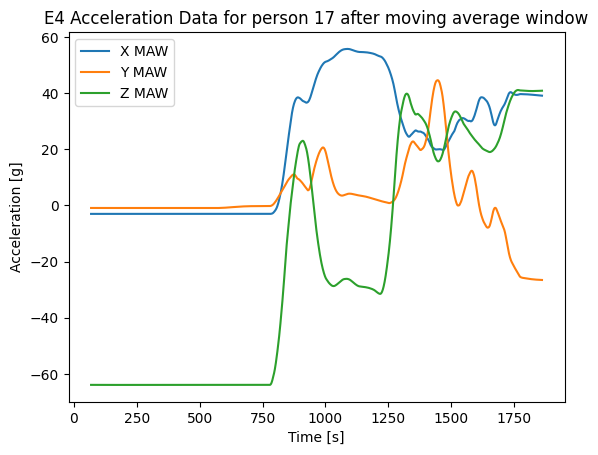

In [39]:
# Complete the ACC data preprocessing for all persons
preprocessed_data = []
for i in range(1, PERSONS+1):
    e4_data, VO2_data = sync_acc_with_VO2(i)
    e4_data = central_moving_average(e4_data, 60, plot=True, person=i)
    e4_data_mag = compute_ACC_magnitude(e4_data)
    e4_data['Magnitude'] = e4_data_mag
    # Plot magnitude
    plt.figure()
    plt.plot(e4_data['Magnitude'], label='Magnitude')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [g]')
    plt.legend()
    plt.title(f'E4 Acceleration Magnitude Data for person {i}')
    plt.show()
    preprocessed_data.append(e4_data)

In [31]:
# Save the preprocessed data
for i, participant in enumerate(preprocessed_data):
    os.makedirs(f"../../preprocessed_dataset/P{i+1}", exist_ok=True)
    participant[['Time[s]','X', 'Y', 'Z']].to_pickle(f"../../preprocessed_dataset/P{i+1}/ACC_E4.pkl")